# TENNIS PLAYERS CLASSIFIERS

## Data preprocessing

In [1]:
#Importing dependencies
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import os
from os import listdir
import shutil
import pywt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

%matplotlib inline 


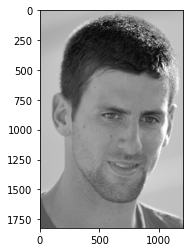

In [2]:
#displaying a test image 
img=cv2.imread('./test_images/roger2.jpg')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray',vmin=0,vmax=255)


### Using Haar-cascades for eyes and face detection

In [3]:
#create haar cascade for face recongnition
face_cascade_path='./cascades/haarcascade_frontalface_default.xml'
eye_cascade_path='./cascades/haarcascade_eye.xml'
face_cascade=cv2.CascadeClassifier(face_cascade_path)
eye_cascade =cv2.CascadeClassifier(eye_cascade_path)
faces=face_cascade.detectMultiScale(gray,1.3,5)

In [4]:
#define a function that return a cropped image if the image have two clear eyes
def cropped_image(img_path):
    img=cv2.imread(img_path)
    if(img is not None):
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # get the faces in the image 
        faces=face_cascade.detectMultiScale(gray,1.3,5)
        # coordinates of the eyes 
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            rect = gray[y:y+h, x:x+w] # plot the rectangles of interest
            rect_output = img[y:y+h, x:x+w]# plotting it on the color image
            eyes = eye_cascade.detectMultiScale(rect) #getting the eyes in the images
            if len(eyes)>=2:
                return rect_output

    

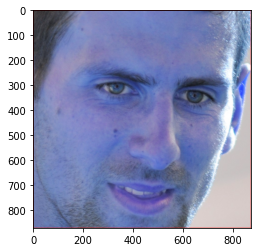

In [5]:
plt.imshow(cropped_image('./test_images/roger2.jpg'))

### Creating a folder for the cropped faces of the tennis players 

In [9]:

path_to_data = "./datasets/"
path_to_cr_data = "./datasets/cropped/"

#creating a folder for croppped images 
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [11]:
#creating a list of the tennis players names to use it later on
names=[]

#loop through each folder inside of the datasets folder
for folder in os.scandir(path_to_data):
    count=1
    if (folder.is_dir()) and (folder.path != './datasets/cropped'):
        
        player_name= folder.path.split('/')[-1]
        names.append(player_name)
        #creating a cropped folder for the cropped images of each tennis player. The folder name will be the tennis players' name 
        name_cropped_folder=path_to_cr_data + player_name
        if not os.path.exists(name_cropped_folder):
            os.makedirs(name_cropped_folder)
        print(f'Creating the folder for {player_name} images')

        # loop through each image in the each folder of images for each tennis player 
        for image in os.scandir(folder.path):
            cropped_img=cropped_image(image.path) 
            if cropped_img is not None:
                cv2.imwrite(name_cropped_folder +'/'+player_name+str(count)+'.png',cropped_img)
                count+=1


Creating the folder for carlos alcaraz images
Creating the folder for novak djokovic images
Creating the folder for rafael nadal images
Creating the folder for roger federer images


### We need to manually delete the images that dont belong to the class 

### Image preprocessing using Wavelet Transform Analysis. Multilevel decomposition 

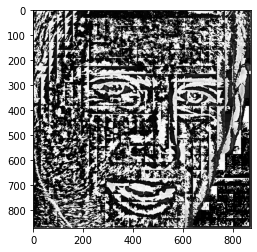

In [18]:

def wavelet(img):
    """Function that takes an image as input and
     return the wavelet transformed image"""

    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray=np.float32(gray)
    gray/=255
    #decomposition to calculate coefficients
    coeff=pywt.wavedec2(gray,'db1',level=5)
    coeffs=list(coeff)
    #omitting approximation coefficients
    coeff[0]*=0
    #recontructing image
    recons_img=pywt.waverec2(coeffs,'db1')
    recons_img*=255
    return np.uint8(recons_img)
    

plt.imshow(wavelet(cropped_image('./test_images/roger2.jpg')),cmap='gray')
    

### Transforming the images and creating our dataset 

In [19]:
X=[]
y=[]

# integer that will represent each tennis players name (our labels)
count=0
for name in names:
    folder=path_to_cr_data + name
    
    print(folder)
    
    for img in os.listdir( folder):
        img_path=folder + '/'+ img
        img=cv2.imread(img_path)
        #resize the original image
        scaled_img=cv2.resize(img,(32,32))
        transformed_img=wavelet(scaled_img)
        #reshaping the images before stacking together as one is color and the other one in grey 
        stacked_img=np.vstack((scaled_img.reshape(32*32*3,1),transformed_img.reshape(32*32,1)))

        # we are going to save the stucked images in X and its labels in y 
        X.append(stacked_img)
        y.append(count)
    count+=1



./datasets/cropped/carlos alcaraz
./datasets/cropped/novak djokovic
./datasets/cropped/rafael nadal
./datasets/cropped/roger federer


In [20]:
print(len(X[0]))
#reshaping the numpy array and changing the type to float
X=np.array(X).reshape(len(X),4096).astype('float')
y=np.array(y)
#checking the length of our dataset
X.shape

4096


(629, 4096)

### Checking if our dataset is balanced 

In [21]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3]), array([189, 196, 122, 122], dtype=int64))

In [22]:
names

['carlos alcaraz', 'novak djokovic', 'rafael nadal', 'roger federer']

We have significant less images for Rafael Nadal and Roger Federer. We will need to balance our dataset or use other techniques to handdle this, such as weighting the loss function to give heavier weights to those unrepresented labels 

## Splitting the dataset

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=1994,
                                               shuffle=True)

In [24]:
X_train.shape

(503, 4096)

In [25]:
X_test.shape

(126, 4096)

## Model Selection using GridSearchCV

In [26]:
#import dependencies
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')



In [27]:
# Creating our grid_search pipeline
clf={'svc':SVC(gamma='auto', probability=True),'logistic_regression':LogisticRegression(),'rfc': RandomForestClassifier()}
params={'svc':{'clf__C':[1,10,100,100],'clf__kernel':['linear','poly','rbf']},
   'logistic_regression':{'clf__penalty':['l1','none'],'clf__C':[.0001,0.1,1,5,10],'clf__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']},
   'rfc':{'clf__n_estimators':[1,5,10,100,100]}}


In [28]:
class Models:

    """ This class performs grid search CV to choose the best parameters for each classifier and return 
    the best models ( for each classifier return the model with the parameters that give the best training score), 
    the train scores and the test scores """
    
    def __init__(self,clf,params,X_train,X_test,y_train,y_test):
        self.params=params
        self.clf=clf
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
    
    def model_selection(self):

        best_models={}
        train_scores={}
        test_scores={}
        
        for c in list(self.clf.keys()):
            pipeline=Pipeline([('scaler',StandardScaler()),('clf',self.clf[c])])
            grid_pipe=GridSearchCV(pipeline,self.params[c])
            #fit each model 
            grid_pipe.fit(self.X_train,self.y_train)
            # retriving the parameters
            best_models[c]=grid_pipe.best_params_
            best_estimator=grid_pipe.best_estimator_
            train_scores[c]=grid_pipe.best_score_

            #predicting on the the test data 
            test_scores[c]=best_estimator.score(self.X_test,self.y_test)

            
        return best_models, train_scores,test_scores
    

    


In [29]:
model1=Models(clf,params,X_train,X_test,y_train,y_test)
best_models,train_scores,test_scores=model1.model_selection()

In [30]:
best_models

{'svc': {'clf__C': 1, 'clf__kernel': 'linear'},
 'logistic_regression': {'clf__C': 0.0001,
  'clf__penalty': 'none',
  'clf__solver': 'lbfgs'},
 'rfc': {'clf__n_estimators': 100}}

In [31]:
#Displaying the train scores for each classifier 
train_scores

{'svc': 0.8748118811881188,
 'logistic_regression': 0.8906732673267326,
 'rfc': 0.7396831683168317}

In [32]:
#Displaying the test scores for each classifier 
test_scores

{'svc': 0.8968253968253969,
 'logistic_regression': 0.873015873015873,
 'rfc': 0.7698412698412699}

## Performing Data Augmentation 

In [35]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3]), array([144, 156,  99, 104], dtype=int64))

We are going to performs different methods for data augmentation. We will increase the number of images for those tennis players who are underepresented to the number of images of the tennis player with  the most images

In [69]:
import random 
random.seed(1994)

def horizontal_flipping(img):
    return cv2.flip(img,-1)

def gaussian_noise(img):
    return img+ np.random.normal(0,00.1,img.shape[0])

def shifting(img):
    return np.roll(img,np.random.randint(-10,10))


def augmentation(X_train,y_train,n=None,under_repr_label=None):
    """X: our array of images
       y: label of those images
       n: number of augmented images we want to generate
       under_repr_label: the label of the underrepresented tennis player (int)"""
    
    
    X_augmented=X_train
    y_augmented=y_train

    X=X_train
    y=y_train

    if under_repr_label!=None:
        
        i= np.where(y_train == under_repr_label)[0]
        # maximum number of images for tennis player 
        k=np.max(np.unique(y_train,return_counts=True))
        n=k-len(i)
        X=X_train[i,:]
        y=y_train[i]
    


    for i in range(n):
        random_idx=np.random.random_integers(0,X.shape[0]-1)
        random_img=X[random_idx]
        y_augmented=np.append(y_augmented,y[random_idx])
        #random data augmentation technique 
        j= np.random.random_integers(0,2)
        lst=[horizontal_flipping,gaussian_noise,shifting]
        img_aug=lst[j](random_img)
        #reshaping the image to add with the others 
        X_augmented=np.vstack([X_augmented,img_aug.reshape(X[0].shape)])

    
    return X_augmented,y_augmented
        

In [70]:
#getting the images for the underrepresented tennis players

labels=[2,3]

X_augmented=X_train
y_augmented=y_train
for label in labels:
    X_augmented,y_augmented=augmentation(X_augmented,y_augmented,under_repr_label=label)

    




In [71]:
np.unique(y_augmented, return_counts=True)

(array([0, 1, 2, 3]), array([144, 156, 156, 156], dtype=int64))

In [72]:
# augmenting the training images by n
# n=400
# X_augmented,y_augmented=augmentation(X_augmented,y_augmented,n)

In [73]:
print(X_augmented.shape)
print(y_augmented.shape)

#shuffle the data
randomize = np.arange(len(X_augmented))
np.random.shuffle(randomize)
X_augmented = X_augmented[randomize]
y_augmented = y_augmented[randomize]

(612, 4096)
(612,)


Trying the models after balancing the data 

In [74]:
model2=Models(clf,params,X_augmented,X_test,y_augmented,y_test)
best_models,train_scores, test_scores=model2.model_selection()

In [75]:
train_scores

{'svc': 0.8725976276156204,
 'logistic_regression': 0.8725443156070904,
 'rfc': 0.7713714514194322}

In [76]:
test_scores

{'svc': 0.8968253968253969,
 'logistic_regression': 0.8809523809523809,
 'rfc': 0.7698412698412699}

We can see that random forest model is overfitting after balancing the data with data augmentation techniques. This might be explained by the small size of the training data (over 500 images) with some labels with only 99 images. We also can reduce the model complexity to deal with the problem of overfitting. Example: for random forest we can reduce the number of trees, limit the max_depth parameter... In general, the first approach would be collecting more images for the tennis players. 